# Orthorectify GOES-R RGB images


Orthorectify red, "green", and blue bands of GOES ABI for a single set of observations from GOES-16 and GOES-17.

This notebook demonstrates the use of the [goes_ortho](https://github.com/spestana/goes-ortho/blob/master/examples/orthorectify_abi_example.ipynb) functions, and RGB plotting is based on [this notebook](https://github.com/daniellelosos/True-Color-Image_GOES-R-ABI-L1b-Radiances).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import goes_ortho

# import get_dem function from https://github.com/uw-cryo/asp-binder-demo/blob/6f03afadc7f4c6e13422da6d5f480c7f6762b47b/asp_binder_utils.py
from asp_binder_utils import get_dem

# for plotting geotiff rasters
import rasterio as rio
import rasterio.plot as rioplt

I am using [this](https://github.com/uw-cryo/asp-binder-demo/blob/6f03afadc7f4c6e13422da6d5f480c7f6762b47b/asp_binder_utils.py) extremely handy function, `get_dem()` from the [UW Terrain Analysis and Cryosphere Observation Lab](https://github.com/uw-cryo).

In [2]:
dem_filepath = './dem/tuolumne_dem.tif'

get_dem(demtype='SRTMGL1_E', bounds=(-121, 36, -118, 41), out_fn=dem_filepath, proj='EPSG:4326')

'./dem/tuolumne_dem.tif'

---

Use the `download-goes.py` script to download GOES ABI-L1b-RadC products for channels 1, 2, and 3, for both GOES-16 and GOES-17 on March 3rd, 2020.

In [16]:
#!python ./download-goes.py --bucket noaa-goes16 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C01 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [15]:
#!python ./download-goes.py --bucket noaa-goes16 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C02 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [14]:
#!python ./download-goes.py --bucket noaa-goes16 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C03 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [13]:
#!python ./download-goes.py --bucket noaa-goes17 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C01 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [12]:
#!python ./download-goes.py --bucket noaa-goes17 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C02 --bounds 30 50 -125 -105 --dir /storage/GOES/

In [11]:
#!python ./download-goes.py --bucket noaa-goes17 --year 2020 --month 3 --days 3 3  --product ABI-L1b-RadC --channel C03 --bounds 30 50 -125 -105 --dir /storage/GOES/

Here I just have lists of the GOES-16 and -17 ABI channel 1, 2, and 3 images I'll be orthorectifying, and then using to make RGB images.

In [19]:
# GOES-16
goes16_images = ['/storage/GOES/goes16/2020/3/3/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G16_s20200630001139_e20200630003512_c20200630003557.nc',
                 '/storage/GOES/goes16/2020/3/3/ABI-L1b-RadC/00/C02/OR_ABI-L1b-RadC-M6C02_G16_s20200630001139_e20200630003512_c20200630003542.nc',
                 '/storage/GOES/goes16/2020/3/3/ABI-L1b-RadC/00/C03/OR_ABI-L1b-RadC-M6C03_G16_s20200630001139_e20200630003512_c20200630003571.nc']

# GOES-17
goes17_images = ['/storage/GOES/goes17/2020/3/3/ABI-L1b-RadC/00/C01/OR_ABI-L1b-RadC-M6C01_G17_s20200630001176_e20200630003549_c20200630004011.nc',
                 '/storage/GOES/goes17/2020/3/3/ABI-L1b-RadC/00/C02/OR_ABI-L1b-RadC-M6C02_G17_s20200630001176_e20200630003549_c20200630003571.nc',
                 '/storage/GOES/goes17/2020/3/3/ABI-L1b-RadC/00/C03/OR_ABI-L1b-RadC-M6C03_G17_s20200630001176_e20200630003549_c20200630004001.nc']

For each of the three GOES-16 images, create an "ortho map" with `goes_ortho.make_ortho_map()` that describes how the original image in ABI scan angle units translates to latitude and longitude, given the parallax effect caused by local terrain. Then use this "ortho map" in `goes_ortho.orthorectify_abi()` to orthorectify the ABI image and output a new NetCDF file clipped to the bounds of the DEM we're using.

In [10]:
for image_path in goes16_images:

    # create a new filename
    new_filename = image_path.split('/')[-1].split('.')[0] + '_orthorectified.nc'
    
    # create the mapping between scan angle coordinates and lat/lon given the GOES satellite position and our DEM
    ortho_map = goes_ortho.make_ortho_map(image_path, 
                                          dem_filepath)

    # specify which data variables from the original ABI product we want in our new orthorectified file
    data_vars = ['Rad'] # I'm only selecting the Radiance product. 
    
    # Note, because we've supplied Radiance to orthorectify_abi(), we will also get reflectance (for bands 1-6) or brightness temperature (for bands 7-16)
    
    # Apply the "ortho map" and save a new NetCDF file with data variables from the original file
    ds = goes_ortho.orthorectify_abi(image_path, 
                                     ortho_map,
                                     data_vars,
                                     out_filename=new_filename)


RUNNING: make_ortho_map()

Opening GOES ABI image...

Get inputs: projection information from the ABI radiance product
...done

Opening DEM file...

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset>
Dimensions:         (latitude: 2160, longitude: 3240)
Coordinates:
  * longitude       (longitude) float64 -119.8 -119.8 -119.8 ... -118.9 -118.9
  * latitude        (latitude) float64 38.1 38.1 38.1 38.1 ... 37.5 37.5 37.5
    dem_px_angle_x  (latitude, longitude) float64 -0.09106 -0.09106 ... -0.09056
    dem_px_angle_y  (latitude, longitude) float64 0.1011 0.1011 ... 0.09999
Data variables:
    elevation       (latitude, longitude) float32 2117.2366 ... 3168.3154
Attributes:
    longitude_of_projection_origin:       -75.0
    semi_major_axis:                      6378137.0
    semi_

...done

Output this result to a new NetCDF file
Saving file as: OR_ABI-L1b-RadC-M6C03_G16_s20200630001139_e20200630003512_c20200630003571_orthorectified.nc
...done


Now do the same for the three GOES-17 images.

In [20]:
for image_path in goes17_images:

    # create a new filename
    new_filename = image_path.split('/')[-1].split('.')[0] + '_orthorectified.nc'
    
    # create the mapping between scan angle coordinates and lat/lon given the GOES satellite position and our DEM
    ortho_map = goes_ortho.make_ortho_map(image_path, 
                                          dem_filepath)

    # specify which data variables from the original ABI product we want in our new orthorectified file
    data_vars = ['Rad'] # I'm only selecting the Radiance product. 
    
    # Note, because we've supplied Radiance to orthorectify_abi(), we will also get reflectance (for bands 1-6) or brightness temperature (for bands 7-16)
    
    # Apply the "ortho map" and save a new NetCDF file with data variables from the original file
    ds = goes_ortho.orthorectify_abi(image_path, 
                                     ortho_map,
                                     data_vars,
                                     out_filename=new_filename)


RUNNING: make_ortho_map()

Opening GOES ABI image...

Get inputs: projection information from the ABI radiance product
...done

Opening DEM file...

Create 2D arrays of longitude and latitude from the DEM
...done

For each grid cell in the DEM, compute the corresponding ABI scan angle (x and y, radians)
...done

Create metadata dictionary about this map
...done

Create pixel map dataset
<xarray.Dataset>
Dimensions:         (latitude: 2160, longitude: 3240)
Coordinates:
  * longitude       (longitude) float64 -119.8 -119.8 -119.8 ... -118.9 -118.9
  * latitude        (latitude) float64 38.1 38.1 38.1 38.1 ... 37.5 37.5 37.5
    dem_px_angle_x  (latitude, longitude) float64 0.03955 0.03955 ... 0.04192
    dem_px_angle_y  (latitude, longitude) float64 0.1044 0.1044 ... 0.1031
Data variables:
    elevation       (latitude, longitude) float32 2117.2366 ... 3168.3154
Attributes:
    longitude_of_projection_origin:       -137.0
    semi_major_axis:                      6378137.0
    semi_min

...done

Output this result to a new NetCDF file
Saving file as: OR_ABI-L1b-RadC-M6C03_G17_s20200630001176_e20200630003549_c20200630004001_orthorectified.nc
...done


Open our six new orthorectified datasets:

In [21]:
# GOES-16
goes_16_C01 = xr.open_dataset('OR_ABI-L1b-RadC-M6C01_G16_s20200630001139_e20200630003512_c20200630003557_orthorectified.nc')
goes_16_C02 = xr.open_dataset('OR_ABI-L1b-RadC-M6C02_G16_s20200630001139_e20200630003512_c20200630003542_orthorectified.nc')
goes_16_C03 = xr.open_dataset('OR_ABI-L1b-RadC-M6C03_G16_s20200630001139_e20200630003512_c20200630003571_orthorectified.nc')

# GOES-17
goes_17_C01 = xr.open_dataset('OR_ABI-L1b-RadC-M6C01_G17_s20200630001176_e20200630003549_c20200630004011_orthorectified.nc')
goes_17_C02 = xr.open_dataset('OR_ABI-L1b-RadC-M6C02_G17_s20200630001176_e20200630003549_c20200630003571_orthorectified.nc')
goes_17_C03 = xr.open_dataset('OR_ABI-L1b-RadC-M6C03_G17_s20200630001176_e20200630003549_c20200630004001_orthorectified.nc')

The function below for creating RGB images from GOES-R ABI reflectance is based on [this notebook](Adapted from https://github.com/daniellelosos/True-Color-Image_GOES-R-ABI-L1b-Radiances).

In [22]:
def makeABIrgb_fromReflectance(R_ref, G_ref, B_ref):
    
    ''' Create RGB images given GOES-R ABI Channel 01, 02, and 03 datasets.
        Adapted from https://github.com/daniellelosos/True-Color-Image_GOES-R-ABI-L1b-Radiances
        
        returns:
                RGB: "True Color" RGB
                RGB_veggie: "False Color" RGB
    '''
    
    # Apply range limits for each channel. Reflectance values must be between 0 and 1.
    R_ref = np.clip(R_ref, 0, 1)
    G_ref = np.clip(G_ref, 0, 1)
    B_ref = np.clip(B_ref, 0, 1)
    
    # Apply a gamma correction to the image to correct ABI detector brightness
    gamma = 2.2
    Red = np.power(R_ref, 1/gamma)
    Green = np.power(G_ref, 1/gamma)
    Blue = np.power(B_ref, 1/gamma)
    
    # GOES-R Series satellites do not have a channel in the visible green range. Band 3 is a NIR channel typically used to monitor vegetation.
    # Calculate the "True" Green Band to serve as a green proxy for the RGB True Color image, using a fractional combination.
    # Source: "Generation of GOES‐16 True Color Imagery without a Green Band" - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018EA000379
    Green_true = 0.45 * Red + 0.1 * Green + 0.45 * Blue
    Green_true = np.clip(Green_true, 0, 1)  # Apply band limits again, just in case.
    
    # Combine three RGB channels with a stacked array, then display the resulting images.
    
    # The RGB array with the raw veggie band
    RGB_veggie = np.dstack([Red, Green, Blue])
    
    # The RGB array for the true color image
    RGB = np.dstack([Red, Green_true, Blue])
    
    return RGB, RGB_veggie

In [23]:
goes16_RGB, goes16_RGB_veggie = makeABIrgb_fromReflectance(goes_16_C02.ref.data, goes_16_C03.ref.data, goes_16_C01.ref.data)

In [24]:
goes17_RGB, goes17_RGB_veggie = makeABIrgb_fromReflectance(goes_17_C02.ref.data, goes_17_C03.ref.data, goes_17_C01.ref.data)

Plot the GOES-16 and -7 RGB images that have been orthorectified:

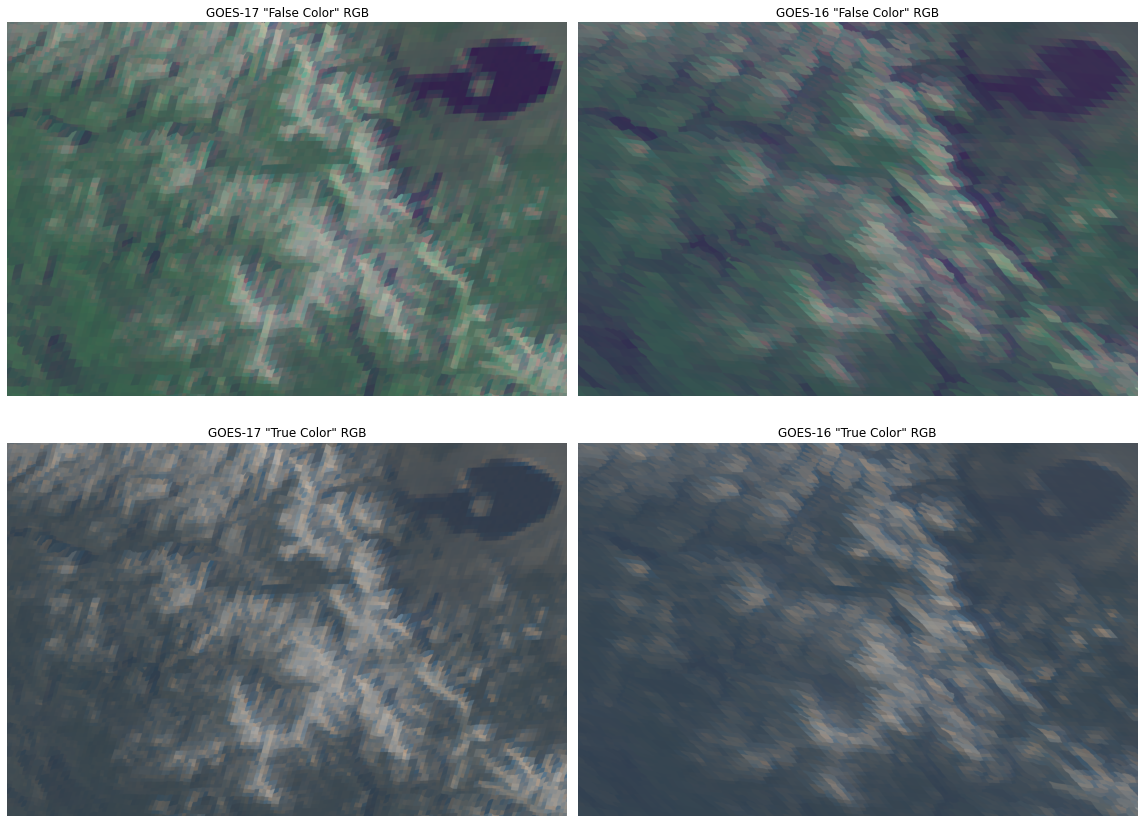

In [25]:
# set up plot figure
fig, ax = plt.subplots(2, 2, figsize=(16, 12), tight_layout=True)
[ax1, ax2, ax3, ax4] = ax.flatten()

# GOES-17 False Color: RGB using the NIR "Veggie" Band
ax1.imshow(goes17_RGB_veggie)
ax1.set_title('GOES-17 "False Color" RGB')
ax1.axis('off')

# GOES-16 False Color: RGB using the NIR "Veggie" Band
ax2.imshow(goes16_RGB_veggie)
ax2.set_title('GOES-16 "False Color" RGB')
ax2.axis('off')

# GOES-17 True Color: RGB for the true color image
ax3.imshow(goes17_RGB)
ax3.set_title('GOES-17 "True Color" RGB')
ax3.axis('off')

# GOES-16 True Color: RGB for the true color image
ax4.imshow(goes16_RGB)
ax4.set_title('GOES-16 "True Color" RGB')
ax4.axis('off');